In [1]:
import mani_skill.envs
import gymnasium as gym
from mani_skill.utils.wrappers import RecordEpisode
from tqdm import tqdm
from IPython.display import Video
from robots.simple_fetch import SimpleFetch



env = gym.make("Empty-v1", 
               render_mode="rgb_array",
               obs_mode="none",
               reward_mode="none",
               control_mode="pd_joint_pos",
               robot_uids="simp_fetch")
env = RecordEpisode(env, "./videos", save_trajectory=False)
print(env.agent.keyframes.keys())

/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/torch/random.py:183: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


dict_keys(['rest'])


/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_episode_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_episode_steps` for environment variables or `env.get_wrapper_attr('max_episode_steps')` that will search the reminding wrappers.
  logger.warn(
/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(


In [2]:
import sapien
import torch


env.reset()
kf = env.agent.keyframes["rest"]
env.agent.robot.set_qpos(kf.qpos)

# if running on a GPU environment you have to
# apply the changes to environment state
if env.gpu_sim_enabled:
    env.scene._gpu_apply_all() # applies changes
    env.scene.px.gpu_update_articulation_kinematics() # updates robot link poses necessary to render correctly
    env.scene._gpu_fetch_all() # updates GPU buffers
env.render() # call this to update the rendering
for i in tqdm(range(100)):
    # with pd_joint_pos control we try to get the robot to maintain the same joint
    # positions as the keyframe
    action = torch.zeros((1, 4))
    action = torch.rand((1, 4)) - 0.5
    action[0, 0] = 1000
    # action[0, :2] = 1000
    obs, reward, terminated, truncated, info = env.step(action)
env.flush_video("example2")
Video("./videos/example2.mp4", embed=True, width=640) # Watch our replay

/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.gpu_sim_enabled to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gpu_sim_enabled` for environment variables or `env.get_wrapper_attr('gpu_sim_enabled')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 100/100 [00:00<00:00, 143.78it/s]


## Test Custom Env

In [1]:
import gymnasium as gym
from mani_skill.utils.wrappers import RecordEpisode
import mani_skill.envs
import torch
import time

from envs import soccer_play

num_envs = 512 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PlaySoccer-v1", 
               render_mode="rgb_array",
               obs_mode="rgb",
               num_envs=num_envs,
               reward_mode="none",
               control_mode="pd_joint_pos",
               robot_uids="simp_fetch")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
print("This is the initial observation:", obs)
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

Here we are


/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/torch/random.py:183: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


# -------------------------------------------------------------------------- #
Task ID: PlaySoccer-v1, 512 parallel environments, sim_backend=gpu
obs_mode=rgb, control_mode=pd_joint_pos
render_mode=rgb_array, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Dict('agent': Dict('qpos': Box(-inf, inf, (512, 5), float32), 'qvel': Box(-inf, inf, (512, 5), float32)), 'extra': Dict(), 'sensor_param': Dict('fetch_head': Dict('extrinsic_cv': Box(-inf, inf, (512, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (512, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (512, 3, 3), float32))), 'sensor_data': Dict('fetch_head': Dict('rgb': Box(0, 255, (512, 128, 128, 3), uint8))))
(single) action space: Box(-1.0, 1.0, (4,), float32)
# -------------------------------------------------------------------------- #
This is the initial observation: {'agent': {'qpos': tensor([[-1.6064, -0.4911,  0.1457,  0.0000,  0.0000],
        [-1.6749, -0.3097,  0.2687,  0.0000,  0.0000],
    

dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['fetch_head'])
dict_keys(['rgb'])
torch.Size([512, 128, 128, 3])


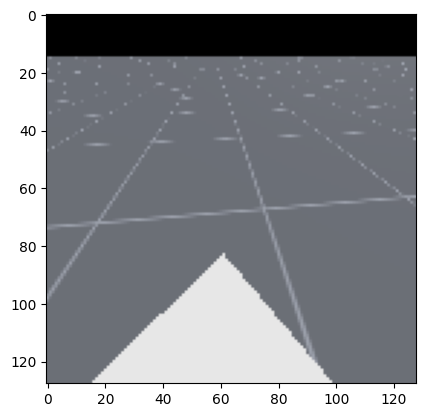

In [2]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['fetch_head'].keys())
print(obs['sensor_data']['fetch_head']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['fetch_head']['rgb'][0].cpu().numpy())

## Record a Video (From Robot's Perspective)

In [2]:
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
from IPython.display import Video
import envs.soccer_play as soccer_play



num_envs = 4 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PlaySoccer-v1", 
               render_mode="rgb_array", # (for fpv use "sensors", for external use "rgb_array")
               obs_mode="rgb",
               num_envs=num_envs,
               reward_mode="none",
               control_mode="pd_joint_pos",
               robot_uids="simp_fetch")
env = RecordEpisode(env, "./videos", max_steps_per_video=1000, save_trajectory=False)

obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
env.close()

Video("./videos/0.mp4", embed=True, width=640)


Here we are
Creating the ball


  0%|          | 0/100 [00:00<?, ?it/s]